# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Read Data

In [2]:
nrows = 100000

# load in the data
print('start')
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', nrows = nrows)
print('azdias done', azdias.shape)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', nrows = nrows)
print('customers done', customers.shape)
train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
print('train done', train.shape)
test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
print('test done', test.shape)

azdias.columns = [col.lower() for col in azdias.columns]
customers.columns = [col.lower() for col in customers.columns]
train.columns = [col.lower() for col in train.columns]
test.columns = [col.lower() for col in test.columns]

print('col lower done')

start


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


azdias done (100000, 366)
customers done (100000, 369)
train done (42962, 367)
test done (42833, 366)
col lower done


# Prepare Column Hierarchy

In [3]:
person_cols_list = ['AGER_TYP','ALTERSKATEGORIE_GROB','ANREDE_KZ','CJT_GESAMTTYP',
'FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER',
'FINANZ_UNAUFFAELLIGER','FINANZ_HAUSBAUER','FINANZTYP','GEBURTSJAHR',
'GFK_URLAUBERTYP','GREEN_AVANTGARDE','HEALTH_TYP','LP_LEBENSPHASE_FEIN',
'LP_LEBENSPHASE_GROB','LP_FAMILIE_FEIN','LP_FAMILIE_GROB','LP_STATUS_FEIN',
'LP_STATUS_GROB','NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE','RETOURTYP_BK_S',
'SEMIO_SOZ','SEMIO_FAM','SEMIO_REL','SEMIO_MAT',
'SEMIO_VERT','SEMIO_LUST','SEMIO_ERL','SEMIO_KULT',
'SEMIO_RAT','SEMIO_KRIT','SEMIO_DOM','SEMIO_KAEM',
'SEMIO_PFLICHT','SEMIO_TRADV','SHOPPER_TYP','SOHO_KZ','TITEL_KZ','VERS_TYP','ZABEOTYP']

household_cols_list = ['ALTER_HH','ANZ_PERSONEN','ANZ_TITEL','HAUSHALTSSTRUKTUR',
'HH_EINKOMMEN_SCORE','D19_KK_KUNDENTYP','D19_KONSUMTYP','D19_GESAMT_ANZ_12',
'D19_GESAMT_ANZ_24','D19_BANKEN_ANZ_12','D19_BANKEN_ANZ_24','D19_TELKO_ANZ_12',
'D19_TELKO_ANZ_24','D19_VERSI_ANZ_12','D19_VERSI_ANZ_24','D19_VERSAND_ANZ_12',
'D19_VERSAND_ANZ_24','D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM','D19_GESAMT_DATUM',
'D19_BANKEN_OFFLINE_DATUM','D19_BANKEN_ONLINE_DATUM','D19_BANKEN_DATUM','D19_TELKO_OFFLINE_DATUM',
'D19_TELKO_ONLINE_DATUM','D19_TELKO_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM',
'D19_VERSAND_DATUM','D19_VERSI_OFFLINE_DATUM','D19_VERSI_ONLINE_DATUM','D19_VERSI_DATUM',
'D19_GESAMT_ONLINE_QUOTE_12','D19_BANKEN_ONLINE_QUOTE_12','D19_VERSAND_ONLINE_QUOTE_12','W_KEIT_KIND_HH','WOHNDAUER_2008']

bldg_cols_list = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','GEBAEUDETYP','GEOSCORE_KLS7','KBA05_HERSTTEMP','KBA05_MODTEMP',
'KONSUMNAEHE','MIN_GEBAEUDEJAHR','OST_WEST_KZ','WOHNLAGE']

rr4_cols_list = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015']

rr3_cols_list = ['KBA05_ALTER1','KBA05_ALTER2','KBA05_ALTER3','KBA05_ALTER4',
'KBA05_ANHANG','KBA05_ANTG1','KBA05_ANTG2','KBA05_ANTG3',
'KBA05_ANTG4','KBA05_AUTOQUOT','KBA05_BAUMAX','KBA05_CCM1',
'KBA05_CCM2','KBA05_CCM3','KBA05_CCM4','KBA05_DIESEL',
'KBA05_FRAU','KBA05_GBZ','KBA05_HERST1','KBA05_HERST2',
'KBA05_HERST3','KBA05_HERST4','KBA05_HERST5','KBA05_KRSAQUOT',
'KBA05_KRSHERST1','KBA05_KRSHERST2','KBA05_KRSHERST3','KBA05_KRSKLEIN',
'KBA05_KRSOBER','KBA05_KRSVAN','KBA05_KRSZUL','KBA05_KW1',
'KBA05_KW2','KBA05_KW3','KBA05_MAXAH','KBA05_MAXBJ',
'KBA05_MAXHERST','KBA05_MAXSEG','KBA05_MAXVORB','KBA05_MOD1',
'KBA05_MOD2','KBA05_MOD3','KBA05_MOD4','KBA05_MOD8',
'KBA05_MOTOR','KBA05_MOTRAD','KBA05_SEG1','KBA05_SEG2',
'KBA05_SEG3','KBA05_SEG4','KBA05_SEG5','KBA05_SEG6',
'KBA05_SEG7','KBA05_SEG8','KBA05_SEG9','KBA05_SEG10',
'KBA05_VORB0','KBA05_VORB1','KBA05_VORB2','KBA05_ZUL1',
'KBA05_ZUL2','KBA05_ZUL3','KBA05_ZUL4','WACHSTUMSGEBIET_NB']

grid_125_cols_list = ['D19_BANKEN_DIREKT_RZ','D19_BANKEN_GROSS_RZ','D19_BANKEN_LOKAL_RZ','D19_BANKEN_REST_RZ',
'D19_BEKLEIDUNG_GEH_RZ','D19_BEKLEIDUNG_REST_RZ','D19_BIO_OEKO_RZ','D19_BILDUNG_RZ',
'D19_BUCH_RZ','D19_DIGIT_SERV_RZ','D19_DROGERIEARTIKEL_RZ','D19_ENERGIE_RZ',
'D19_FREIZEIT_RZ','D19_GARTEN_RZ','D19_HANDWERK_RZ','D19_HAUS_DEKO_RZ',
'D19_KINDERARTIKEL_RZ','D19_KOSMETIK_RZ','D19_LEBENSMITTEL_RZ','D19_NAHRUNGSERGAENZUNG_RZ',
'D19_RATGEBER_RZ','D19_REISEN_RZ','D19_SAMMELARTIKEL_RZ','D19_SCHUHE_RZ',
'D19_SONSTIGE_RZ','D19_TECHNIK_RZ','D19_TELKO_MOBILE_RZ','D19_TELKO_REST_RZ',
'D19_TIERARTIKEL_RZ','D19_VERSICHERUNGEN_RZ','D19_VOLLSORTIMENT_RZ','D19_VERSAND_REST_RZ','D19_WEIN_FEINKOST_RZ']

postcode_cols_list = ['BALLRAUM','EWDICHTE','INNENSTADT','PLZ']

rr1_cols_list = ['GEBAEUDETYP_RASTER', 'KKK','MOBI_REGIO','ONLINE_AFFINITAET','REGIOTYP']

plz8_cols_list = ['KBA13_ALTERHALTER_30','KBA13_ALTERHALTER_45','KBA13_ALTERHALTER_60','KBA13_ALTERHALTER_61',
'KBA13_ANZAHL_PKW','KBA13_AUDI','KBA13_AUTOQUOTE','KBA13_BJ_1999',
'KBA13_BJ_2000','KBA13_BJ_2004','KBA13_BJ_2006','KBA13_BJ_2008',
'KBA13_BJ_2009','KBA13_BMW','KBA13_CCM_1000','KBA13_CCM_1200',
'KBA13_CCM_1400','KBA13_CCM_0_1400','KBA13_CCM_1500','KBA13_CCM_1401_2500',
'KBA13_CCM_1600','KBA13_CCM_1800','KBA13_CCM_2000','KBA13_CCM_2500',
'KBA13_CCM_2501','KBA13_FAB_ASIEN','KBA13_FAB_SONSTIGE','KBA13_FIAT',
'KBA13_FORD','KBA13_HALTER_20','KBA13_HALTER_25','KBA13_HALTER_30',
'KBA13_HALTER_35','KBA13_HALTER_40','KBA13_HALTER_45','KBA13_HALTER_50',
'KBA13_HALTER_55','KBA13_HALTER_60','KBA13_HALTER_65','KBA13_HALTER_66',
'KBA13_HERST_ASIEN','KBA13_HERST_AUDI_VW','KBA13_HERST_BMW_BENZ','KBA13_HERST_EUROPA',
'KBA13_HERST_FORD_OPEL','KBA13_HERST_SONST','KBA13_KMH_110','KBA13_KMH_140',
'KBA13_KMH_180','KBA13_KMH_0_140','KBA13_KMH_140_210','KBA13_KMH_211',
'KBA13_KMH_250','KBA13_KMH_251','KBA13_KRSAQUOT','KBA13_KRSHERST_AUDI_VW',
'KBA13_KRSHERST_BMW_BENZ','KBA13_KRSHERST_FORD_OPEL','KBA13_KRSSEG_KLEIN','KBA13_KRSSEG_OBER',
'KBA13_KRSSEG_VAN','KBA13_KRSZUL_NEU','KBA13_KW_30','KBA13_KW_40',
'KBA13_KW_50','KBA13_KW_60','KBA13_KW_0_60','KBA13_KW_70',
'KBA13_KW_61_120','KBA13_KW_80','KBA13_KW_90','KBA13_KW_110',
'KBA13_KW_120','KBA13_KW_121','KBA13_MAZDA','KBA13_MERCEDES',
'KBA13_MOTOR','KBA13_NISSAN','KBA13_OPEL','KBA13_PEUGEOT',
'KBA13_RENAULT','KBA13_SEG_GELAENDEWAGEN','KBA13_SEG_GROSSRAUMVANS','KBA13_SEG_KLEINST',
'KBA13_SEG_KLEINWAGEN','KBA13_SEG_KOMPAKTKLASSE','KBA13_SEG_MINIVANS','KBA13_SEG_MINIWAGEN',
'KBA13_SEG_MITTELKLASSE','KBA13_SEG_OBEREMITTELKLASSE','KBA13_SEG_OBERKLASSE','KBA13_SEG_SONSTIGE',
'KBA13_SEG_SPORTWAGEN','KBA13_SEG_UTILITIES','KBA13_SEG_VAN','KBA13_SEG_WOHNMOBILE',
'KBA13_SITZE_4','KBA13_SITZE_5','KBA13_SITZE_6','KBA13_TOYOTA',
'KBA13_VORB_0','KBA13_VORB_1','KBA13_VORB_1_2','KBA13_VORB_2',
'KBA13_VORB_3','KBA13_VW','PLZ8','PLZ8_ANTG1',
'PLZ8_ANTG2','PLZ8_ANTG3','PLZ8_ANTG4','PLZ8_BAUMAX','PLZ8_HHZ','PLZ8_GBZ']

comm_cols_list = ['ARBEIT','EINWOHNER','GKZ','ORTSGR_KLS9','RELAT_AB']

col_dict = {'person': [col.lower() for col in person_cols_list],
            'household': [col.lower() for col in household_cols_list],
            'building': [col.lower() for col in bldg_cols_list],
            'rr4': [col.lower() for col in rr4_cols_list],
            'rr3': [col.lower() for col in rr3_cols_list],
            'rr1': [col.lower() for col in rr1_cols_list],
            '125': [col.lower()[:-3] for col in grid_125_cols_list],#it appears these columns are mislabeled as _rz
            'postcode': [col.lower() for col in postcode_cols_list],
            'plz8': [col.lower() for col in plz8_cols_list],
            'community': [col.lower() for col in comm_cols_list],
            'dnu': [],
            'customer': ['customer_group', 'online_purchase', 'product_group'],
            'response': ['response']
           }

summer = 0 
for col in customers.columns:
    counter = 0
    for hier, col_list in col_dict.items():
        if col in col_list: counter += 1
            
    if counter == 0:        
        if 'cjt' in col: col_dict['person'].append(col)
        elif 'online_quote_12' in col: col_dict['household'].append(col)
        elif 'ccm' in col: col_dict['plz8'].append(col)
        elif 'kba13' in col: col_dict['plz8'].append(col)
        elif 'alterskategorie' in col: col_dict['person'].append(col)
        else:
            print('{0} null rate = {1:.2f}%'.format(col, 100 * azdias[col].isnull().sum() / azdias.shape[0]))
            col_dict['dnu'].append(col)
    
    for hier, col_list in col_dict.items():
        if hier == 'response': continue
        for col in col_list:
            if col not in customers.columns:
                col_list.remove(col)
    
    for hier, col_list in col_dict.items():
        if col in col_list: summer += 1

print('{0:.2f}% Exlained'.format(100 * summer / len(customers.columns)))

lnr null rate = 0.00%
akt_dat_kl null rate = 8.38%
alter_kind1 null rate = 90.91%
alter_kind2 null rate = 96.73%
alter_kind3 null rate = 99.31%
alter_kind4 null rate = 99.87%
anz_kinder null rate = 8.38%
anz_statistische_haushalte null rate = 10.53%
cameo_intl_2015 null rate = 11.14%
d19_buch_cd null rate = 0.00%
d19_konsumtyp_max null rate = 0.00%
d19_letzter_kauf_branche null rate = 29.20%
d19_lotto null rate = 29.20%
d19_soziales null rate = 29.20%
dsl_flag null rate = 10.53%
eingefuegt_am null rate = 10.53%
eingezogenam_hh_jahr null rate = 8.38%
extsel992 null rate = 73.46%
firmendichte null rate = 10.53%
gemeindetyp null rate = 11.00%
hh_delta_flag null rate = 12.20%
kk_kundentyp null rate = 65.87%
kombialter null rate = 0.00%
konsumzelle null rate = 10.53%
mobi_raster null rate = 10.53%
rt_kein_anreiz null rate = 0.54%
rt_schnaeppchen null rate = 0.54%
rt_uebergroesse null rate = 5.90%
strukturtyp null rate = 11.00%
umfeld_alt null rate = 11.03%
umfeld_jung null rate = 11.03%
ung

# Delete Null Rows

In [4]:
def inv_null_rows(azdias, ttl):
    y_val_list = []
    x_val_list = np.linspace(0, 1, 101)
    null_rows = (azdias.isnull().sum(axis = 1) / azdias.shape[1])
    for idx, x_val in enumerate(x_val_list):
        y_val = (null_rows > x_val).sum()
        y_val_list.append(y_val)
        if idx > 10 and y_val_list[-2] > y_val_list[-1] + 1000:
            print(y_val_list[-2])

    fig, ax = plt.figure(), plt.subplot(111)
    ax.plot(x_val_list, y_val_list)
    ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_title(ttl)
    return null_rows

14382
10448
8393
5264


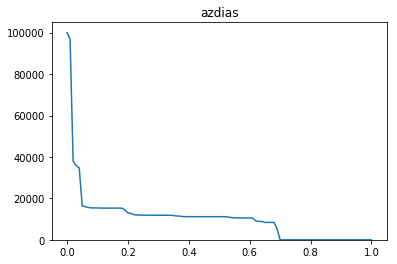

In [5]:
null_rows = inv_null_rows(azdias, 'azdias')

In [6]:
azdias = azdias.loc[null_rows < 0.6]

28880
25503
23781


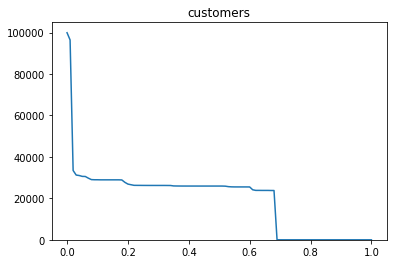

In [7]:
null_rows = inv_null_rows(customers, 'customers')

In [8]:
customers = customers.loc[null_rows < 0.6]

6969


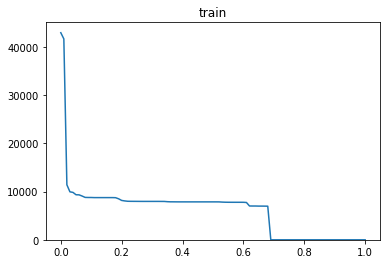

In [9]:
null_rows = inv_null_rows(train, 'train')

In [10]:
#train = train.loc[null_rows < 0.6]

6893
5639


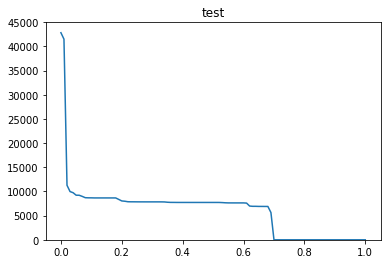

In [11]:
null_rows = inv_null_rows(test, 'test')

In [12]:
#test = test.loc[null_rows < 0.6]

# Delete Columns with High Null Rate

In [13]:
 def inv_null_cols(azdias, ttl, null_rt):
    use_cols = []
    for col in azdias.columns:
        if col in col_dict['dnu']: continue
        else: use_cols.append(col)

    null_cnt = (azdias[use_cols].isnull().sum() / azdias.shape[0])
    null_cnt = null_cnt.loc[null_cnt > null_rt]

    fig, ax = plt.figure(figsize = (12, 5)), plt.subplot(111)
    null_cnt.plot(kind = 'bar', ax = ax, title = ttl)

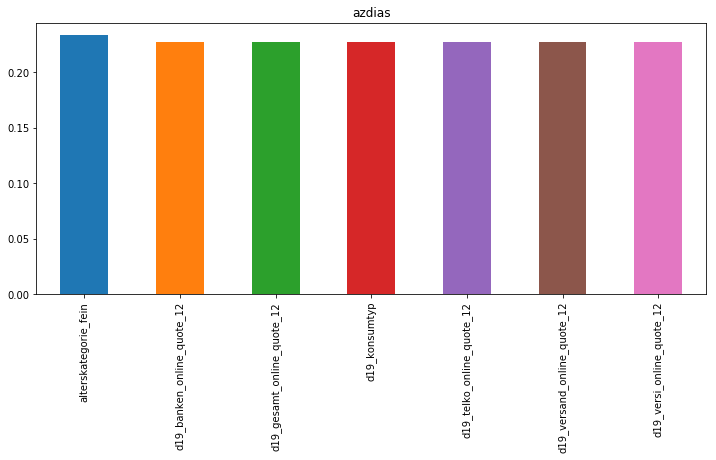

In [14]:
inv_null_cols(azdias, 'azdias', 0.1)

a 20% null rate is probably ok so I am going to keep these columns and dump dnu cols

In [15]:
azdias.drop(col_dict['dnu'], axis = 1, inplace = True)

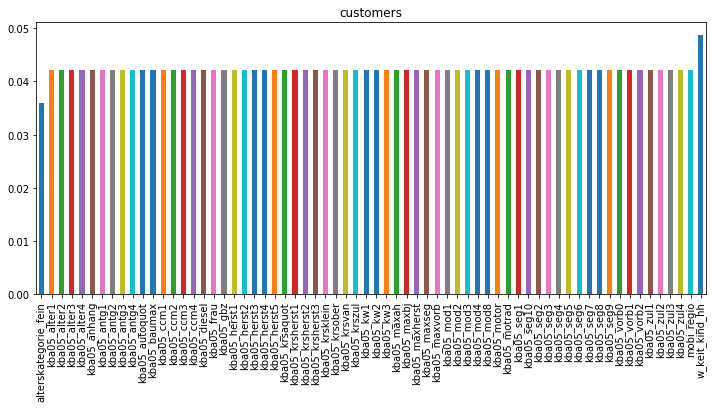

In [16]:
inv_null_cols(customers, 'customers', 0.03)

In [17]:
customers.drop(col_dict['dnu'], axis = 1, inplace = True)

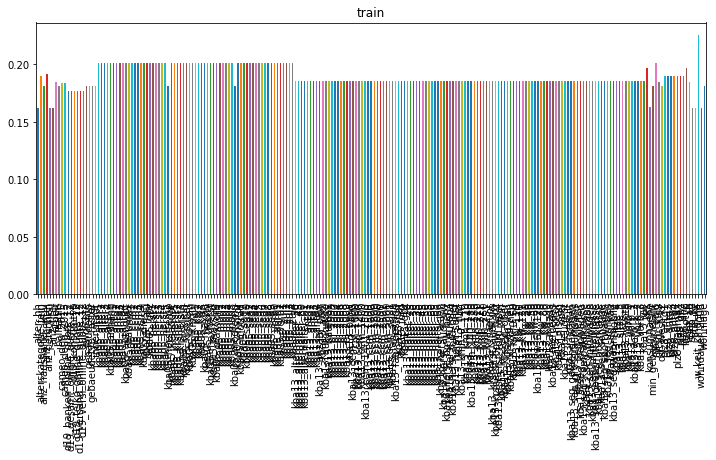

In [18]:
inv_null_cols(train, 'train', 0.03)

In [19]:
#train.drop(col_dict['dnu'], axis = 1, inplace = True)

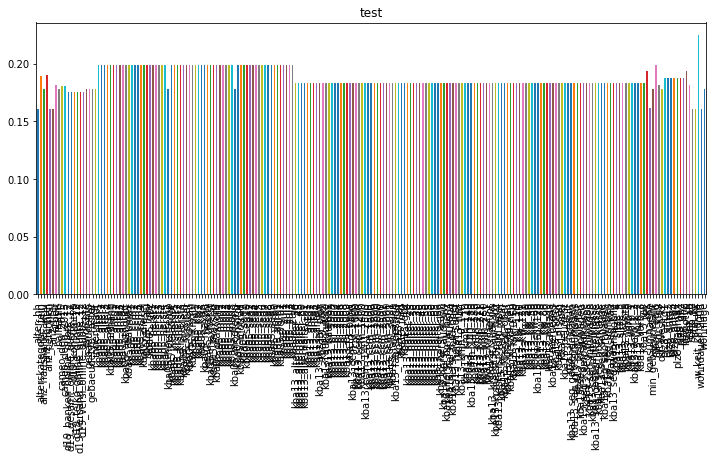

In [20]:
inv_null_cols(test, 'test', 0.03)

In [21]:
#test.drop(col_dict['dnu'], axis = 1, inplace = True)

# Define Update Dict Function

In [22]:
def upd_col_dict(col_dict, col, new_col_list):
    for hier, col_list in col_dict.items():
        if '_cat' in hier or '_cont' in hier: continue
        elif hier in ['dnu', 'response']: continue
        
        if col in col_list:
            col_list.remove(col)    
            col_list += new_col_list
            col_list = list(set(col_list))
            
def remove_col(col_dict, col):
    for hier, col_list in col_dict.items():
        if '_cat' in hier or '_cont' in hier: continue
        elif hier in ['dnu', 'customer', 'response']: continue
        
        if col in col_list:
            col_list.remove(col)
            
def repl_w_null(df, col, null_list):
    for null in null_list:
        df[col].replace(to_replace = null, value = np.nan, inplace = True)
        
def check_col_dict(df, col_dict):
    for hier, col_list in col_dict.items():
        if '_cat' in hier or '_cont' in hier: continue
        elif hier in ['dnu']: continue
            
        for col in col_list:
            if col in df.columns: continue
            else: print(col, 'error')

# Handle Categorical Columns

In [23]:
for col in azdias.select_dtypes('O').columns:
    if col in col_dict['dnu']: continue
        
    print(col)
    print(azdias[col].unique())
    print(azdias[col].isnull().sum() / azdias.shape[0])

cameo_deu_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
0.00686240541839
cameo_deug_2015
[8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 nan 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
0.00686240541839
ost_west_kz
['W' 'O']
0.0


In [24]:
def custom_cols(df, upd = False):
    for col in df.select_dtypes('O').columns:
        if col in col_dict['dnu']: continue
        if col in col_dict['customer']: continue
        if col in col_dict['response']: continue

        if col == 'cameo_deu_2015':
            print(col)
            df[col].replace(to_replace = 'XX', value = np.nan, inplace = True)
            dummy_df = pd.get_dummies(df[col], prefix = col, dummy_na = True, drop_first = True)
            df = pd.concat([df.drop(col, axis=1),\
                            dummy_df],\
                            axis=1)
            
            if upd:
                upd_col_dict(col_dict, col, list(dummy_df.columns))

        elif col == 'cameo_deug_2015':
            print(col)
            df[col].replace(to_replace = 'X', value = np.nan, inplace = True)
            df[col] = df[col].astype(float)

        elif col == 'ost_west_kz':
            print(col)
            df[col] = df[col].map({'W': 1, 'O': 0})
            
    return df

In [25]:
azdias = custom_cols(azdias, upd = True)

cameo_deu_2015
cameo_deug_2015
ost_west_kz


In [26]:
customers = custom_cols(customers, upd = False)

cameo_deu_2015
cameo_deug_2015
ost_west_kz


In [27]:
train = custom_cols(train, upd = False)

cameo_deu_2015
cameo_deug_2015
ost_west_kz


In [28]:
test = custom_cols(test, upd = False)

cameo_deu_2015
cameo_deug_2015
ost_west_kz


## Check Dummying

In [29]:
def check_dummy(azdias):
    for col in azdias.select_dtypes('O').columns:
        if col in col_dict['dnu']: continue
        else: print(col)

In [30]:
check_dummy(azdias)

In [31]:
check_dummy(customers)

product_group
customer_group


In [32]:
check_dummy(train)

In [33]:
check_dummy(test)

# Determine Categorical Columns

In [34]:
#grid columns are categorical

#postcode columns are continuous

#within rr1
##GEBAEUDETYP_RASTER & REGIOTYP are categorical

#within plz8 is continuous
##PLZ8_BAUMAX - categorical

#community are continuous

#within household categorical mostly
##ALTER_HH - continuous
##ANZ_PERSONEN - continuous
##ANZ_TITEL - continous
##HH_EINKOMMEN_SCORE - continous
##D19_GESAMT_ONLINE_QUOTE_12 - continous
##D19_BANKEN_ONLINE_QUOTE_12 - continous
##D19_VERSAND_ONLINE_QUOTE_12 - continous
##W_KEIT_KIND_HH - continous
##WOHNDAUER_2008 - continous


#within building categorical mostly
##ANZ_HAUSHALTE_AKTIV - continous
##ANZ_HH_TITEL - continous
##KONSUMNAEHE - continous

#RR4 are categorical

#within RR3 mostly continous
##KBA05_BAUMAX - categorical

#person is generally continous
##AGER_TYP - categorical
##ANREDE_KZ - categorical
##FINANZTYP - categorical
##GFK_URLAUBERTYP - categorical
##GREEN_AVANTGARDE - categorical
##HEALTH_TYP - categorical
##LP_LEBENSPHASE_FEIN - categorical
##LP_LEBENSPHASE_GROB - categorical
##LP_FAMILIE_FEIN - categorical
##LP_FAMILIE_GROB - categorical
##LP_STATUS_FEIN - categorical
##LP_STATUS_GROB - categorical
##NATIONALITAET_KZ - categorical
##PRAEGENDE_JUGENDJAHRE - categorical
##RETOURTYP_BK_S - categorical
##SHOPPER_TYP - categorical
##SOHO_FLAG - categorical
##TITEL_KZ - categorical
##VERS_TYP - categorical
##ZABEOTYP - categorical

cat_cont_dict = {'person': ('cat', ['AGER_TYP'.lower(), 'ANREDE_KZ'.lower(), 'FINANZTYP'.lower(),
                                    'GFK_URLAUBERTYP'.lower(), 'GREEN_AVANTGARDE'.lower(), 'HEALTH_TYP'.lower(),
                                    'LP_LEBENSPHASE_FEIN'.lower(), 'LP_LEBENSPHASE_GROB'.lower(), 'LP_FAMILIE_FEIN'.lower(),
                                    'LP_FAMILIE_GROB'.lower(), 'LP_STATUS_FEIN'.lower(), 'LP_STATUS_GROB'.lower(),
                                    'NATIONALITAET_KZ'.lower(), 'PRAEGENDE_JUGENDJAHRE'.lower(),'RETOURTYP_BK_S'.lower(),
                                    'SHOPPER_TYP'.lower(), 'SOHO_FLAG'.lower(), 'TITEL_KZ'.lower(), 'VERS_TYP'.lower(),
                                    'ZABEOTYP'.lower(), 'cjt_gesamttyp'.lower(), 'cjt_katalognutzer'.lower()]),
                 'household': ('cont', ['ALTER_HH'.lower(), 'ANZ_PERSONEN'.lower(), 'ANZ_TITEL'.lower(),
                                        'HH_EINKOMMEN_SCORE'.lower(), 'D19_GESAMT_ONLINE_QUOTE_12'.lower(),
                                        'D19_BANKEN_ONLINE_QUOTE_12'.lower(), 'D19_VERSAND_ONLINE_QUOTE_12'.lower(),
                                        'W_KEIT_KIND_HH'.lower(), 'WOHNDAUER_2008'.lower()]),
                 'building': ('cont', ['ANZ_HAUSHALTE_AKTIV'.lower(), 'ANZ_HH_TITEL'.lower(), 'KONSUMNAEHE'.lower()]),
                 'rr4': ('cont', []),
                 'rr3': ('cat', ['KBA05_BAUMAX'.lower(), 'KBA05_GBZ']),
                 'rr1': ('cat', ['REGIOTYP'.lower(), 'GEBAEUDETYP_RASTER'.lower()]),
                 '125': ('cont', []),
                 'postcode': ('cat', []),
                 'plz8': ('cat', ['PLZ8_BAUMAX'.lower()]),
                 'community': ('cat', [])}

rev_dict = {'cat': 'cont', 'cont': 'cat'}

do_not_dummy = ['cameo_deu_2015_1B', 'cameo_deu_2015_1C', 'cameo_deu_2015_1D', 'cameo_deu_2015_1E',
  'cameo_deu_2015_2A', 'cameo_deu_2015_2B', 'cameo_deu_2015_2C', 'cameo_deu_2015_2D',
  'cameo_deu_2015_3A', 'cameo_deu_2015_3B', 'cameo_deu_2015_3C', 'cameo_deu_2015_3D',
  'cameo_deu_2015_4A', 'cameo_deu_2015_4B', 'cameo_deu_2015_4C', 'cameo_deu_2015_4D',
  'cameo_deu_2015_4E', 'cameo_deu_2015_5A', 'cameo_deu_2015_5B', 'cameo_deu_2015_5C',
  'cameo_deu_2015_5D', 'cameo_deu_2015_5E', 'cameo_deu_2015_5F', 'cameo_deu_2015_6A',
  'cameo_deu_2015_6B', 'cameo_deu_2015_6C', 'cameo_deu_2015_6D', 'cameo_deu_2015_6E',
  'cameo_deu_2015_6F', 'cameo_deu_2015_7A', 'cameo_deu_2015_7B', 'cameo_deu_2015_7C',
  'cameo_deu_2015_7D', 'cameo_deu_2015_7E', 'cameo_deu_2015_8A', 'cameo_deu_2015_8B',
  'cameo_deu_2015_8C', 'cameo_deu_2015_8D', 'cameo_deu_2015_9A', 'cameo_deu_2015_9B',
  'cameo_deu_2015_9C', 'cameo_deu_2015_9D', 'cameo_deu_2015_9E', 'cameo_deu_2015_nan']

for hier in cat_cont_dict.keys():
    #in this part I have to get rid of the one that I already dummied
    col_dict[hier + '_' + cat_cont_dict[hier][0]] = cat_cont_dict[hier][1]
    col_dict[hier + '_' + rev_dict[cat_cont_dict[hier][0]]] = list(set(col_dict[hier]) -\
                                                                   set(cat_cont_dict[hier][1]) -\
                                                                   set(do_not_dummy))
    
print('done')

done


# Null Dict

In [35]:
null_val_dict = {
    'alter_hh': (0, ),
    'alterskategorie_fein': (-1, 0, 9),
    'alterskategorie_grob': (-1, 0, 9),
    'anz_haushalte_aktiv': (-1, ),
    'anz_hh_titel': (-1, ),
    'anz_personen': (-1, ),
    'anz_titel': (-1, ),
    'arbeit': (9, ),
    'ballraum': (-1, ),
    'cjt_typ': (-1, ),
    'd19_banken_online_quote_12': (-1, ),
    'd19_gesamt_online_quote_12': (-1, ),
    'd19_versand_online_quote_12': (-1, ),
    'ewdichte': (-1, ),
    'finanz': (-1, ),
    'geburtsjahr': (-1, ),
    'hh_einkommen_score': (-1, 0),
    'innenstadt': (-1, ),
    'kba05': (-1, 9),
    'kba13': (-1,), 
    'semio': (-1, 9),
    'kkk': (-1, 0),
    'konsumnaehe': (-1, ),
    'mobi_regio': (6, ),
    'online_affinitaet': (0, ),
    'ortsgr_kls9': (-1, ),
    'plz8': (-1, ),
    'relat_ab': (-1, 9),
    'soho_kz': (-1, ),
    'w_keit_kind_hh': (-1, 0),
    'wohndauer_2008': (-1, 0)
}   

In [36]:
def repl_nulls(azdias):
    cont_grps = ['finanz', 'kba05', 'kba13', 'semio', 'cjt_typ', 'plz8']
    
    for hier, col_list in col_dict.items():
        if '_cont' not in hier: continue
        if hier == 'customer': continue
        if hier == 'response': continue

        upd_flag = False
        for col in col_list:
            for grp in cont_grps:
                if grp in col:
                    upd_flag = True
                    repl_w_null(azdias, col, null_val_dict[grp])
                    break

            if not upd_flag:
                repl_w_null(azdias, col, null_val_dict[col])

In [37]:
repl_nulls(azdias)
print('azdias done')
repl_nulls(customers)
print('customers done')
repl_nulls(train)
print('train done')
repl_nulls(test)
print('test done')

azdias done
customers done
train done
test done


# Fill Nulls

In [38]:
def dummy_null(azdias):
    print('start', azdias.shape[1])
    dummy_col_dict = {}

    for hier, col_list in col_dict.items():
        if '_cat' in hier or '_cont' in hier: continue

        if hier in ['dnu', 'customer', 'response']: continue
        

        print(hier)

        dummy_col_dict[hier] = []

        for col in col_list:
            if col in col_dict[hier + '_cat']:
                dummy_df = pd.get_dummies(azdias[col], prefix = col, dummy_na = True, drop_first = False)
                azdias = pd.concat([azdias.drop(col, axis=1),\
                                    dummy_df],\
                                    axis=1)
                dummy_col_dict[hier] += list(dummy_df.columns)
            elif col in col_dict[hier + '_cont']:
                azdias[col].fillna(value = azdias[col].mean(), inplace = True)
            else:
                '{0} skipped'.format(col)
    
    print('end', azdias.shape[1])
    return azdias, dummy_col_dict

In [39]:
azdias, azd_dummy_dict = dummy_null(azdias)

start 371
person
household
building
rr4
rr3
rr1
125
postcode
plz8
community
end 1126


In [40]:
customers, cust_dummy_dict = dummy_null(customers)

start 374
person
household
building
rr4
rr3
rr1
125
postcode
plz8
community
end 1127


In [41]:
train, train_dummy_dict = dummy_null(train)

start 410
person
household
building
rr4
rr3
rr1
125
postcode
plz8
community
end 1163


In [42]:
test, test_dummy_dict = dummy_null(test)

start 409
person
household
building
rr4
rr3
rr1
125
postcode
plz8
community
end 1159


In [43]:
for dummy_dict in [azd_dummy_dict, cust_dummy_dict]:
    for hier, dummy_col_list in dummy_dict.items():
        for col in col_dict[hier + '_cat']:
            use_dummies = [dummy_col for dummy_col in dummy_col_list if col in dummy_col]
            upd_col_dict(col_dict, col, use_dummies)
            
print('done')

done


In [44]:
in_cust = set(customers.columns) - set(azdias.columns)
in_azd = set(azdias.columns) - set(customers.columns)

rm_cols = list(set(list(in_cust) + list(in_azd)) - set(col_dict['customer']))

for col in rm_cols:
    remove_col(col_dict, col)
    
    if col in azdias.columns: azdias.drop(col, axis = 1, inplace = True)
        
    if col in customers.columns: customers.drop(col, axis = 1, inplace = True)
        
print('azdias', azdias.shape[1])
print('customers', customers.shape[1])

azdias 1123
customers 1126


In [45]:
print('azdias')
check_col_dict(azdias, col_dict)
print('customers')
check_col_dict(customers, col_dict)

azdias
customer_group error
online_purchase error
product_group error
response error
customers
response error


In [46]:
pd.to_pickle(customers, 'clean_cust')
pd.to_pickle(azdias, 'clean_azd')

# Create Scalers

In [52]:
customers = pd.read_pickle('clean_cust')
azdias = pd.read_pickle('clean_azd')

In [53]:
customers = customers[list(azdias.columns) + col_dict['customer']]

print('cust', customers.shape[1], 'azdias', azdias.shape[1])

cust 1126 azdias 1123


In [54]:
for hier, col_list in col_dict.items():
    if '_cat' in hier or '_cont' in hier or hier in ['dnu', 'customer', 'response']: continue
        
    print(hier, 'start')
        
    ss = StandardScaler()
    ss.fit(customers[col_dict[hier]])
    
    for idx, df in enumerate([azdias, customers]):
        df[col_dict[hier]] = ss.transform(df[col_dict[hier]])
        print(hier, idx, 'done')

person start
person 0 done
person 1 done
household start
household 0 done
household 1 done
building start
building 0 done
building 1 done
rr4 start
rr4 0 done
rr4 1 done
rr3 start
rr3 0 done
rr3 1 done
rr1 start
rr1 0 done
rr1 1 done
125 start
125 0 done
125 1 done
postcode start
postcode 0 done
postcode 1 done
plz8 start
plz8 0 done
plz8 1 done
community start
community 0 done
community 1 done


# Factor reduction within hierarchy

In [56]:
for hier, col_list in col_dict.items():
    if '_cat' in hier or '_cont' in hier or hier in ['dnu', 'customer', 'response']: continue
        
    print(hier, len(col_list))

person 224
household 270
building 69
rr4 54
rr3 69
rr1 18
125 285
postcode 3
plz8 128
community 3


person start


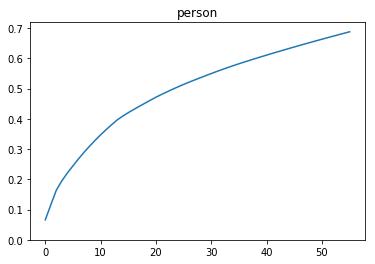

person done
household start


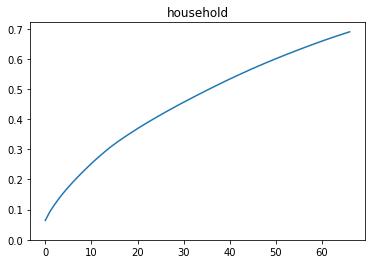

household done
building start


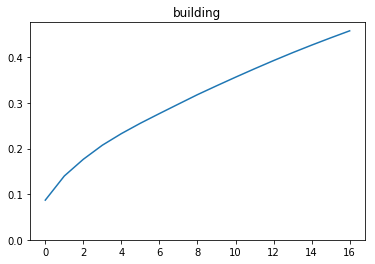

building done
rr4 start


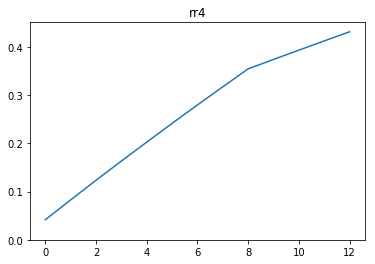

rr4 done
rr3 start


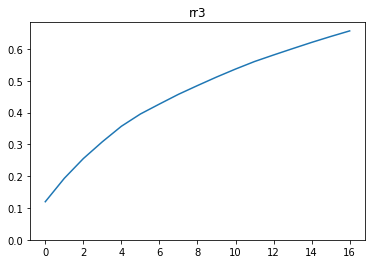

rr3 done
125 start


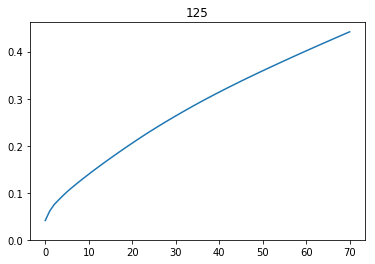

125 done
plz8 start


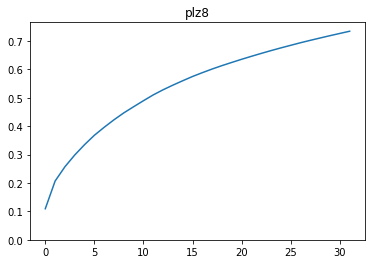

plz8 done


In [57]:
pca_dict = {}

for hier, col_list in col_dict.items():
    if '_cat' in hier or '_cont' in hier or hier in ['dnu', 'customer', 'response']: continue
        
    if hier in ['rr1', 'community', 'postcode']:
        pca_dict[hier + '_cust_data'] = customers[col_dict[hier]].values
        pca_dict[hier + '_azd_data'] = azdias[col_dict[hier]].values
        continue
        
    #rr1, community and postcode are not in need of reduction
    #maybe use a different logic to pca the ones that are heavily dummied
    #and those that are fully of continuous variables
        
    print(hier, 'start')
    
    num_cols = len(col_dict[hier])
    qtr_cols = num_cols // 4
    
    pca = PCA(n_components = np.max([np.min([10, num_cols]), qtr_cols]), random_state = 1)
    pca_dict[hier + '_cust_data'] = pca.fit_transform(customers[col_dict[hier]])
    pca_dict[hier + '_azd_data'] = pca.transform(azdias[col_dict[hier]])
    pca_dict[hier + '_ev'] = pca.explained_variance_ratio_
    pca_dict[hier + '_comp'] = pca.components_
    
    fig, ax = plt.figure(), plt.subplot(111)
    ax.plot(np.cumsum(pca_dict[hier + '_ev']))
    ax.set_title(hier)
    ax.set_ylim([0, ax.get_ylim()[1]])
    plt.show()

    print(hier, 'done')

# New Cust df

In [59]:
cust_counter, azd_counter = 0, 0
comb_df_dict = {}

for key, data in pca_dict.items():
    if '_ev' in key or 'comp' in key: continue
    
    col_pref = key.split('_')[0]
    df_nm = key.split('_')[1]
    
    if df_nm == 'azd': azd_counter += 1
    elif df_nm == 'cust': cust_counter += 1
    
    col_list = ['{0}_{1}'.format(col_pref, idx) for idx in range(data.shape[1])]
    use_df = pd.DataFrame(columns = col_list, data = data)
    
    if (azd_counter == 1 and df_nm == 'azd') or (cust_counter == 1 and df_nm == 'cust'):
        comb_df_dict[df_nm] = use_df
    else:
        comb_df_dict[df_nm] = pd.concat([comb_df_dict[df_nm], use_df], axis = 1)

In [60]:
for key, df in comb_df_dict.items():
    print(key, df.shape)

cust (74497, 297)
azd (89473, 297)


In [61]:
#pd.to_pickle(comb_df_dict, 'comb_df_dict')

In [66]:
comb_df_dict = pd.read_pickle('comb_df_dict')

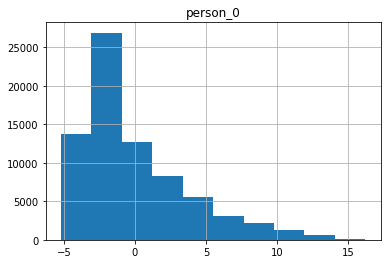

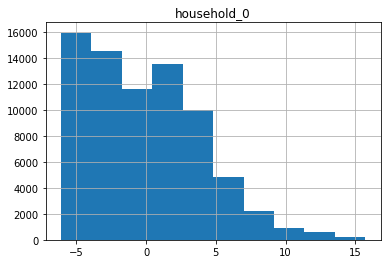

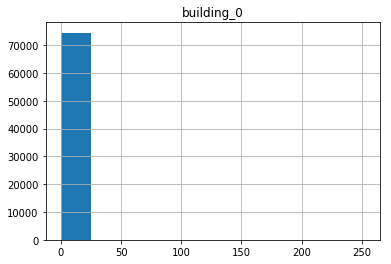

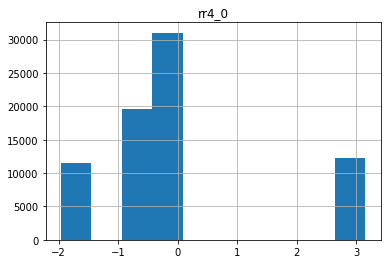

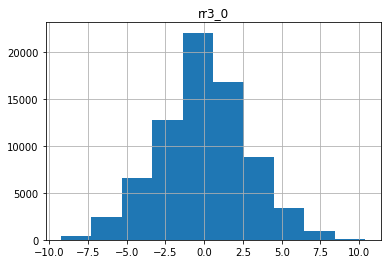

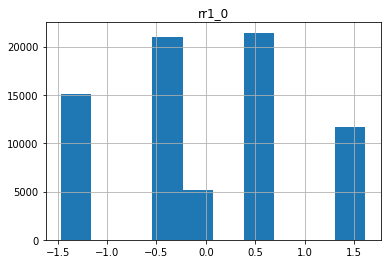

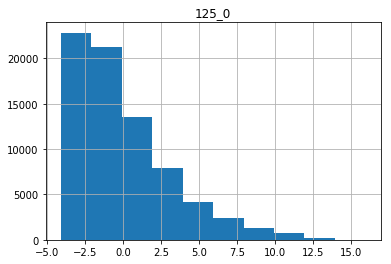

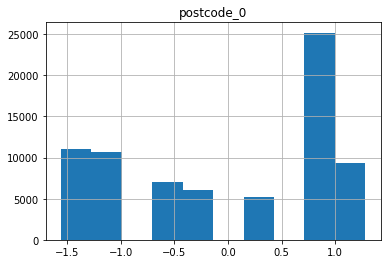

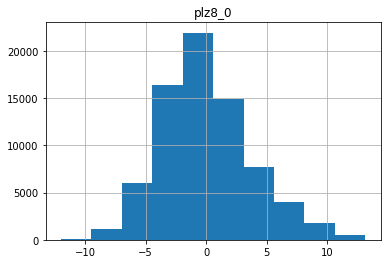

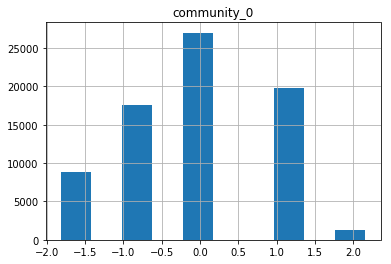

In [65]:
for col in comb_df_dict['cust'].columns:
    if '_0' not in col: continue
    
    comb_df_dict['cust'][col].hist()
    plt.title(col)
    plt.show()

# Scale Principal Components
don't run this section, there is no need to scale principal components

In [113]:
ss = StandardScaler()
mm = MinMaxScaler(feature_range = (-4, 4))

temp_df = ss.fit_transform(comb_df_dict['cust'])
mm.fit(temp_df)

for dataset in ['cust', 'azd']:
    temp_data = ss.transform(comb_df_dict[dataset])
    temp_data = mm.transform(temp_data)
    comb_df_dict[dataset] = pd.DataFrame(columns = comb_df_dict[dataset].columns, data = temp_data)

In [114]:
for key, data in comb_df_dict.items():
    print(key, data.shape)

cust (74497, 297)
azd (89473, 297)


# Run Clustering

In [67]:
kmean = KMeans(n_clusters = 10, max_iter = 100, verbose = 10, n_init = 5, random_state = 1)

In [68]:
kmean.fit(comb_df_dict['cust'])

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 45306882.0369
start iteration
done sorting
end inner loop
Iteration 1, inertia 43765028.1989
start iteration
done sorting
end inner loop
Iteration 2, inertia 43458224.3861
start iteration
done sorting
end inner loop
Iteration 3, inertia 43350940.5011
start iteration
done sorting
end inner loop
Iteration 4, inertia 43295610.9934
start iteration
done sorting
end inner loop
Iteration 5, inertia 43257409.873
start iteration
done sorting
end inner loop
Iteration 6, inertia 43228902.6009
start iteration
done sorting
end inner loop
Iteration 7, inertia 43204346.0048
start iteration
done sorting
end inner loop
Iteration 8, inertia 43179645.454
start iteration
done sorting
end inner loop
Iteration 9, inertia 43153858.9745
start iteration
done sorting
end inner loop
Iteration 10, inertia 43109104.3268
start iteration
done sorting
end inner loop
Iteration 11, inertia 43036886.282
start iteration
done sorting


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=5, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=10)

In [69]:
cust_chars = []
for grp in customers['customer_group'].unique():
    for online in customers['online_purchase'].unique():
        for product in customers['product_group'].unique():
            cust_chars.append((grp, online, product))
            
print('done')

done


('MULTI_BUYER', 0, 'COSMETIC_AND_FOOD')
cust 1.0
azd 1.0


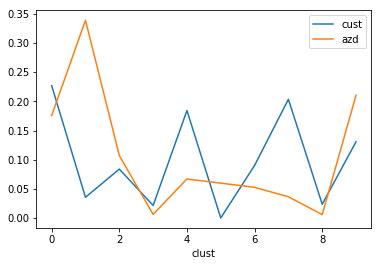

('MULTI_BUYER', 0, 'COSMETIC')
cust 1.0
azd 1.0


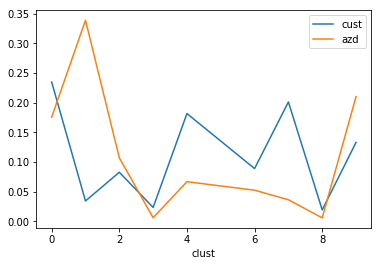

('MULTI_BUYER', 0, 'FOOD')
cust 1.0
azd 1.0


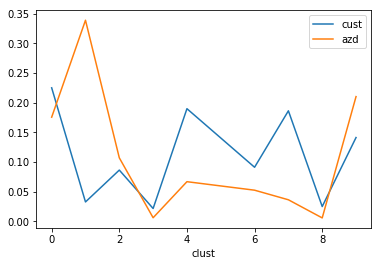

('MULTI_BUYER', 1, 'COSMETIC_AND_FOOD')
cust 1.0
azd 1.0


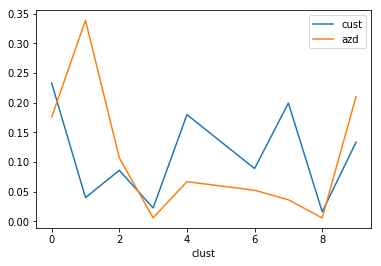

('MULTI_BUYER', 1, 'COSMETIC')
cust 1.0
azd 1.0


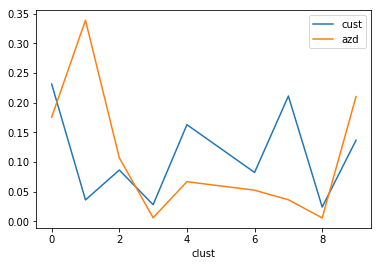

('MULTI_BUYER', 1, 'FOOD')
cust 1.0
azd 1.0


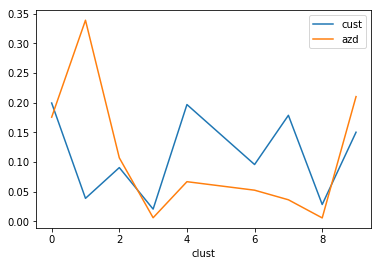

('SINGLE_BUYER', 0, 'COSMETIC_AND_FOOD')


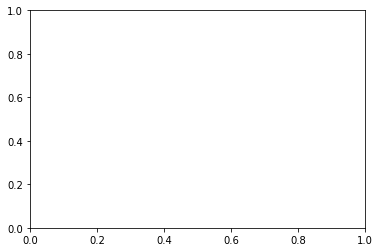

('SINGLE_BUYER', 0, 'COSMETIC')
cust 1.0
azd 1.0


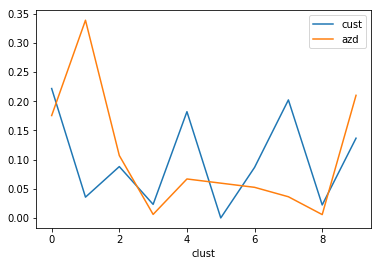

('SINGLE_BUYER', 0, 'FOOD')
cust 1.0
azd 1.0


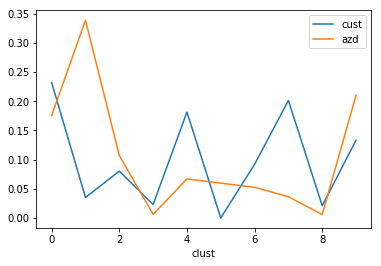

('SINGLE_BUYER', 1, 'COSMETIC_AND_FOOD')


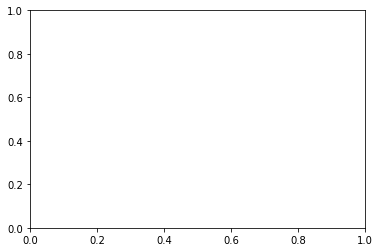

('SINGLE_BUYER', 1, 'COSMETIC')
cust 1.0
azd 1.0


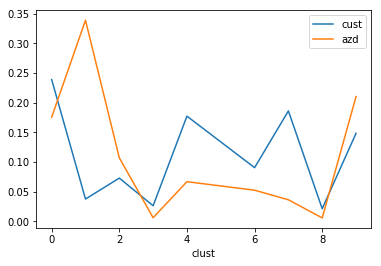

('SINGLE_BUYER', 1, 'FOOD')
cust 1.0
azd 1.0


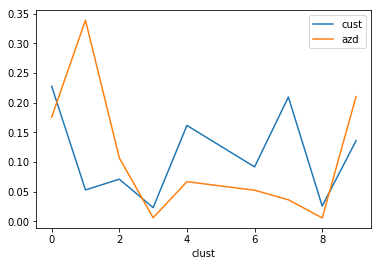

In [70]:
for cust_char in cust_chars:
    print(cust_char)
    for key, df in comb_df_dict.items():
        col_list = list(df.columns)
        if 'clust' in col_list:
            col_list.remove('clust')
            
        df['clust'] = kmean.predict(df[col_list])

        if key == 'cust':
            temp_df = df.merge(customers[col_dict['customer']], how = 'left', left_index = True, right_index = True)
            
            temp_df = temp_df.loc[(temp_df['customer_group'] == cust_char[0]) &\
                                  (temp_df['online_purchase'] == cust_char[1]) &\
                                  (temp_df['product_group'] == cust_char[2])]
            
            if len(temp_df) == 0: break
            
            plt_df = (temp_df.groupby(['clust'])['clust'].count() / temp_df.shape[0])
        else:
            plt_df = (df.groupby(['clust'])['clust'].count() / df.shape[0])
            
        
        print(key, plt_df.sum())
        plt_df.plot(label = key)
            
    plt.legend()
    plt.show()

# Look at dimensions the cluster is away from zero
reset threshold

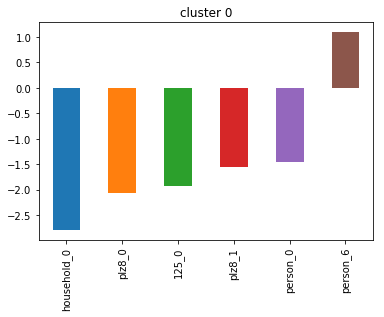

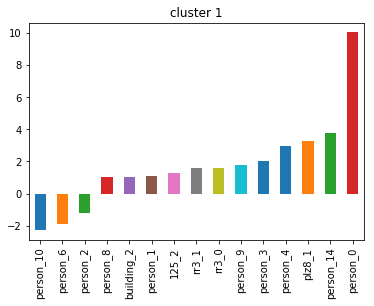

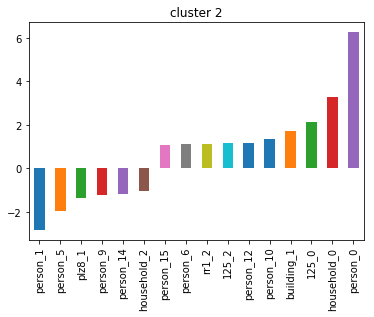

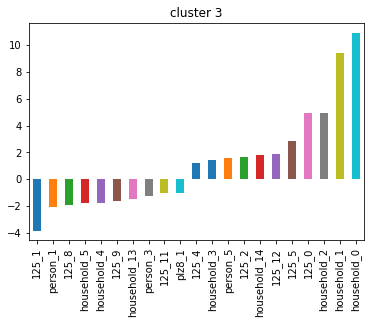

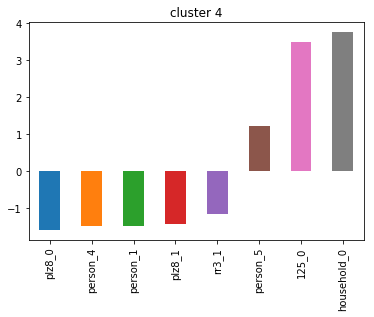

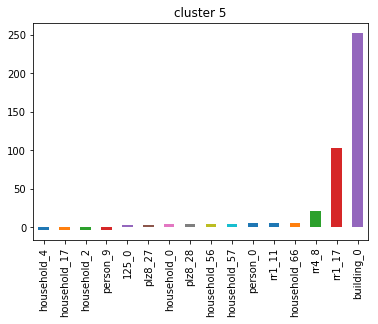

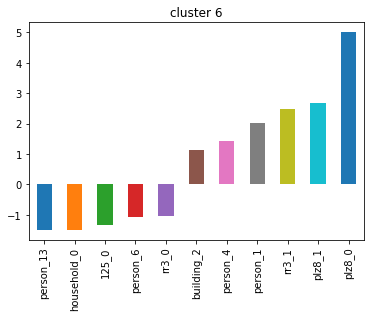

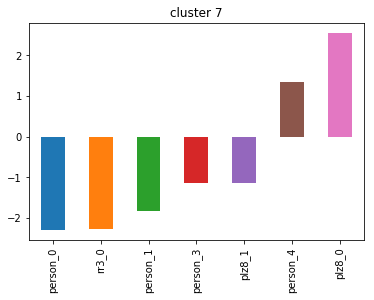

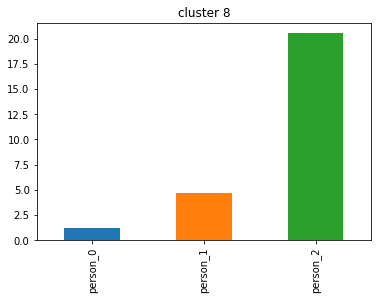

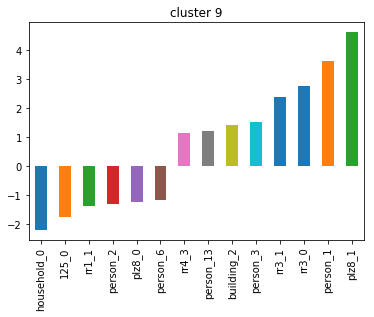

In [73]:
col_list = list(comb_df_dict['cust'].columns)
col_list.remove('clust')
clust_df = pd.DataFrame(columns = col_list, data = kmean.cluster_centers_)

clust_idx = list(range(clust_df.shape[0]))
thresh_dict = dict(zip(clust_idx, [1, 1, 1, 1, 1, 3, 1, 1, 1, 1]))

key_comp_dict = {}

for row in clust_idx:
    thresh = thresh_dict[row]
    clust_coef = clust_df.iloc[row]
    clust_coef.sort_values(inplace = True)
    plt_df = clust_coef.loc[(clust_coef.values > thresh)|(clust_coef.values < -thresh)]
    key_comp_dict[row] = plt_df
    fig, ax = plt.figure(), plt.subplot(111)
    try:
        plt_df.plot(kind = 'bar', ax = ax, title = 'cluster {0}'.format(row))
    except:
        print('no dominant features in cluster {0}'.format(row))

# Interpret the Principal Components

actually I should probably do the clustering first and then do the interpretation because then I can say what are the dimensions of the cluster and how do those map back to the data

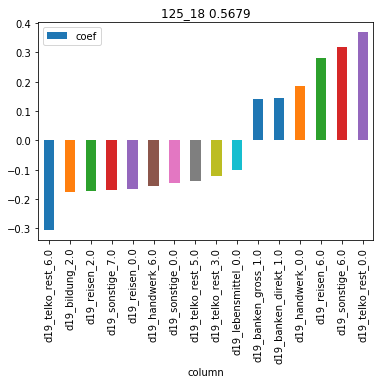

In [74]:
def pca_inspect(pca_ind, val, thresh = 0.1):
    hier = pca_ind.split('_')[0]
    comp_ind = int(pca_ind.split('_')[1])

    coef = pca_dict[hier + '_comp'][comp_ind, :]

    coef_df = pd.DataFrame({'column': customers[col_dict[hier]].columns, 'coef': coef})

    coef_df.loc[abs(coef_df['coef']) > thresh].sort_values(by = 'coef').plot(kind = 'bar', x = 'column', y = 'coef',\
                                                                             title = '{0} {1:.4f}'.format(pca_ind, val))
    
    plt.show()

pca_inspect('125_18', val = 0.5679, thresh = 0.1)

1


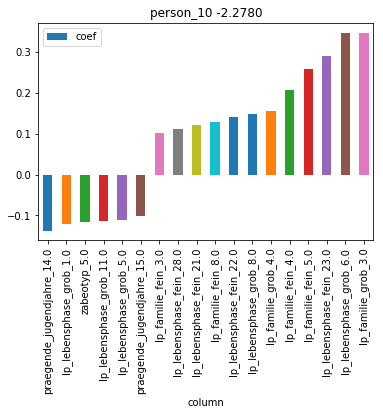

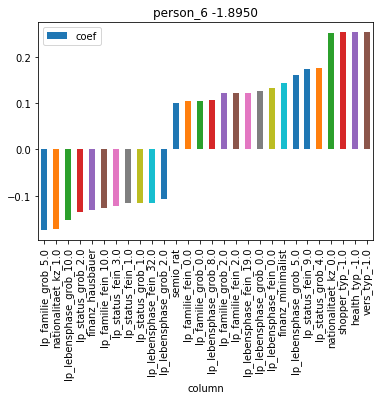

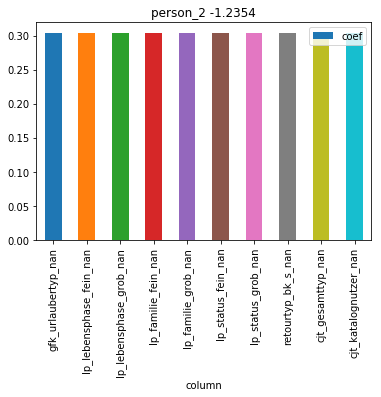

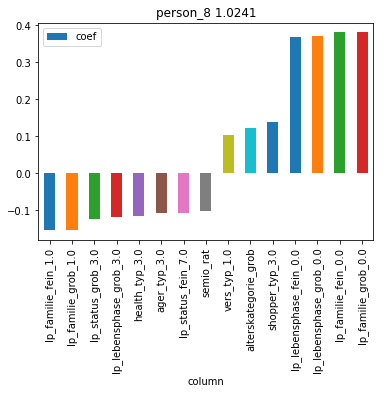

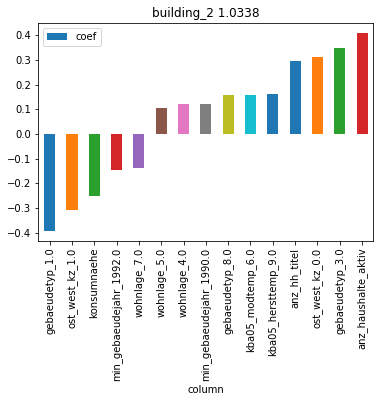

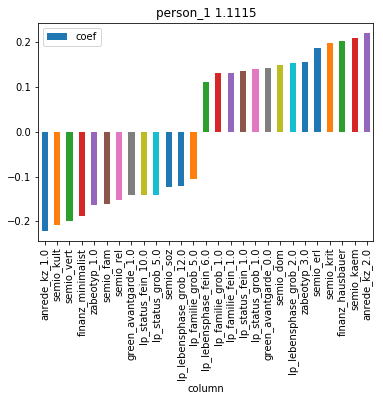

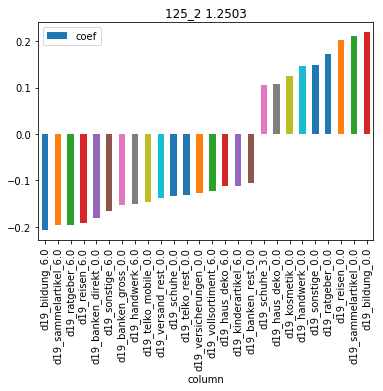

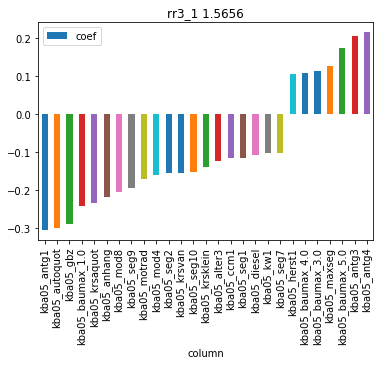

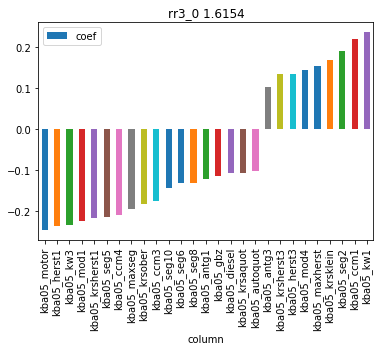

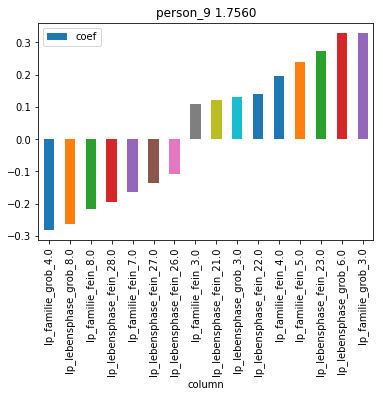

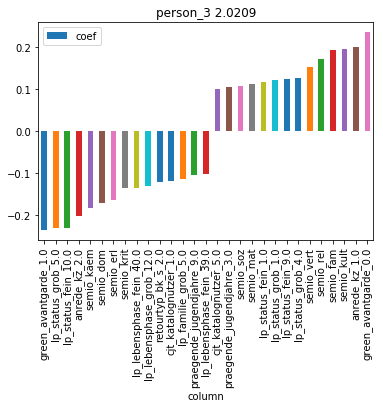

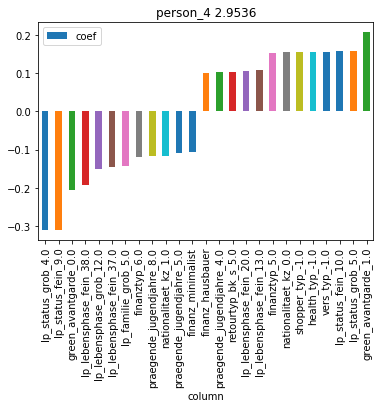

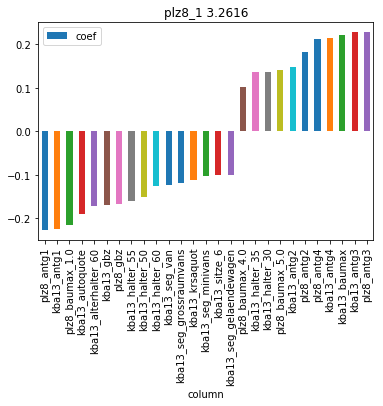

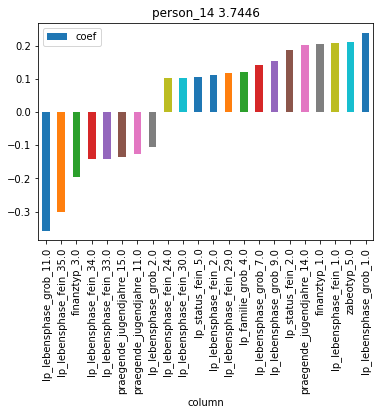

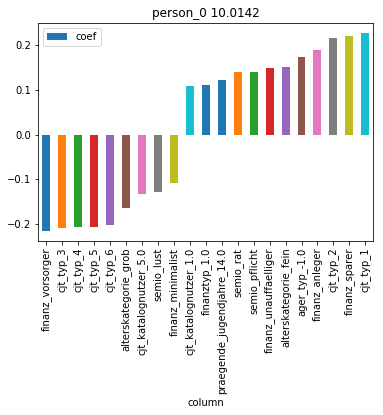

In [90]:
for clust_idx, key_comp in key_comp_dict.items():
    if clust_idx not in [1]: continue
        
    print(clust_idx)
    
    for comp in key_comp.index:
        if 'rr1' in comp: continue
            
        if comp.split('_')[0] + '_comp' not in pca_dict.keys():
            hier, idx = comp.split('_')
            print(comp, col_dict[hier][int(idx)], key_comp[comp])
        else:
            pca_inspect(comp, key_comp[comp])

# Commentary

**Cluster 1**<br>
person_10 (-)
- positive coefficients - appear to be related to single parent households
- negative coefficients - appear to be social media kids single low income

person_6 (-)
- positive coefficients - average earners, house owners, high earners
- negative coefficients - single parents, german name, low income

person_2 (-)
- positive coefficients - null data
- negative coefficients - null data

person_8 (+)
- positive coefficients - demanding shopper
- negative coefficients - single person

building_2 (+)
- positive coefficients - active people, residential + company building professional people, east germany
- negative coefficients - residential building, west germany

person_4 (+)
- positive coefficients - green people, average earner, top earner
- negative coefficients - house earner

plz8_1 (+)
- positive coefficients - # of 6-10 family houses, densely populated
- negative coefficients - non densely populated

person_14 (+)
- positive coefficients - 
- negative coefficients - 

person_0 (+)
- positive coefficients - high spender, not an investor?
- negative coefficients - not a saver

**Cluster 4**<br>
plz8_0
- positive coefficients - lots of BMW
- negative coefficients - lots of slow cars
person_4
- positive coefficients - top earners
- negative coefficieints - lower earners home owners


125_0
- posivie coefficients - drugs and ecologicals
- negative coefficients - house decorations
household_0
- positive coefficients - universal online spenders
- negative coefficients - no transaction activity

**Cluster 5**<br>
- negative coefficients - elevating online banking 
- positive coefficients - no banking info

**Cluster 6**<br>
- negative coefficients - low income, lot's of slow cars
- positive coefficients - aspiring low income, lots of BMW's

**Cluster 7**<br>
- negative coefficients - not a saver
- positive coefficients - high spender, not an investor?

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

It appears that the bertelsmann arvato population are the more affluent part of the german community. Generally it appears that they are coming from less densely populated portions of germany.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

# Treat DNU Columns
in the interpretability section I didn't want to use the columns I didn't have labels for, but there is less cause to ignore them in the prediction segment

In [544]:
pd.to_pickle(train, 'pre_dnu_train')

In [545]:
pd.to_pickle(test, 'pre_dnu_test')

In [76]:
train = pd.read_pickle('pre_dnu_train')
test = pd.read_pickle('pre_dnu_test')

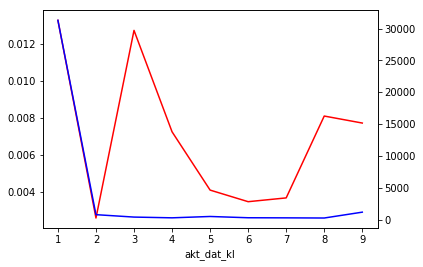

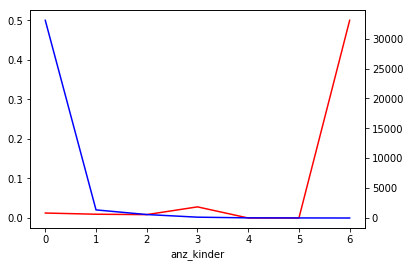

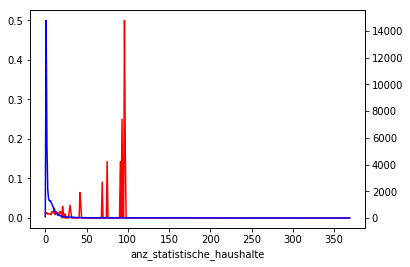

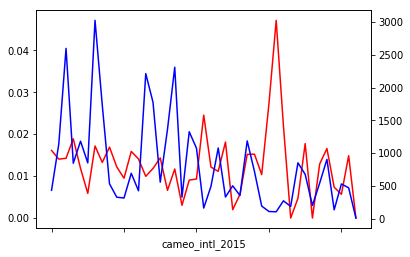

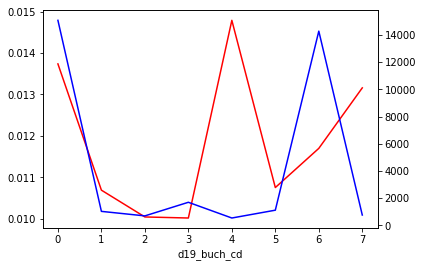

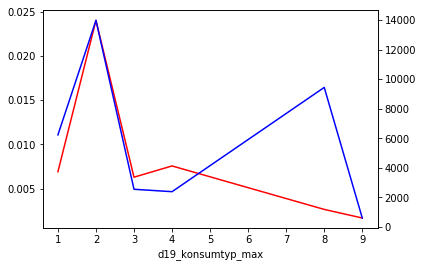

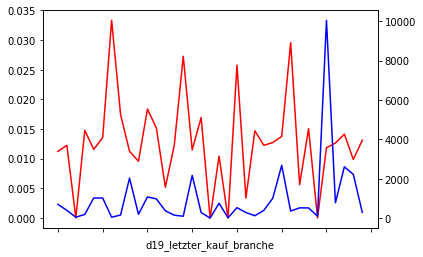

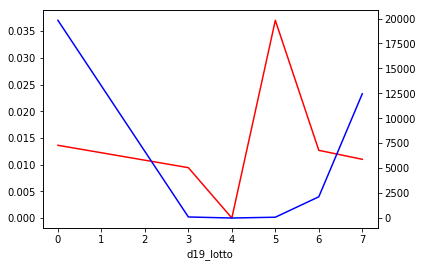

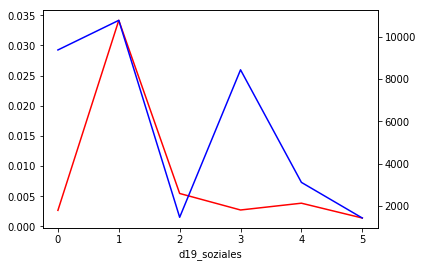

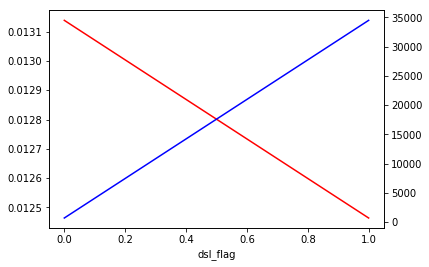

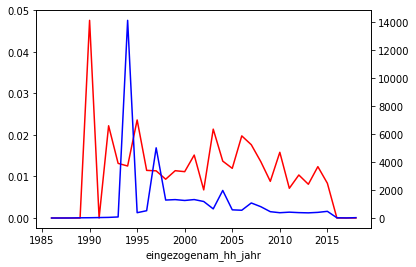

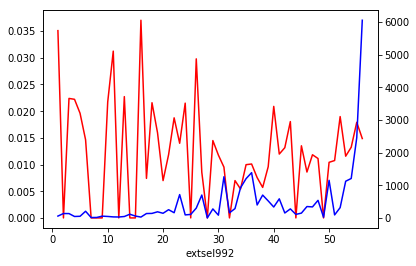

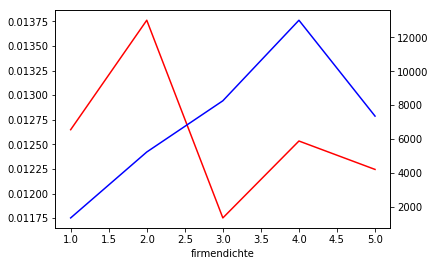

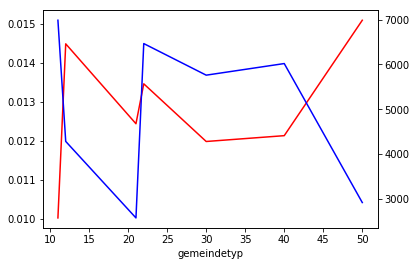

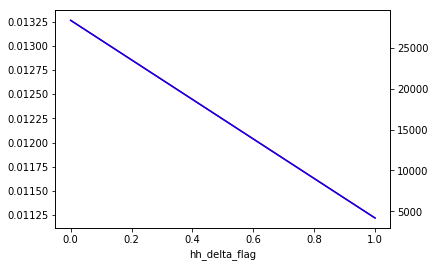

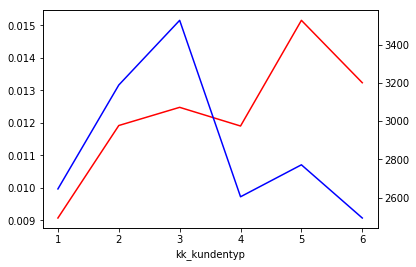

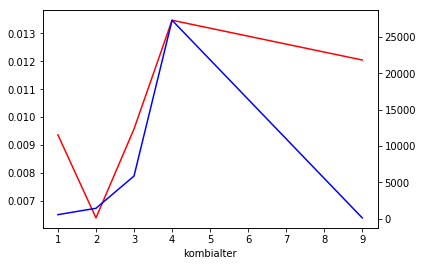

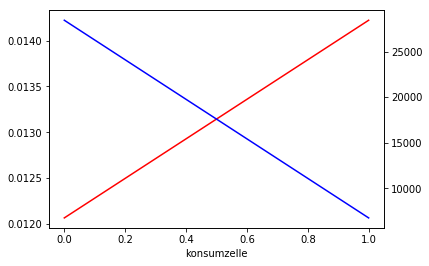

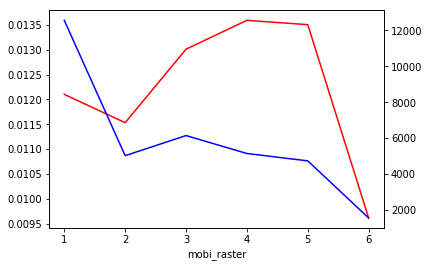

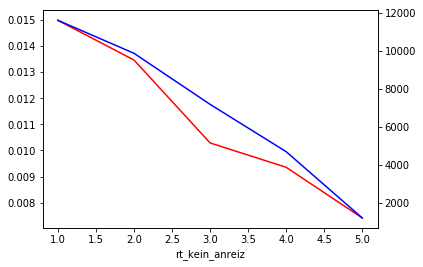

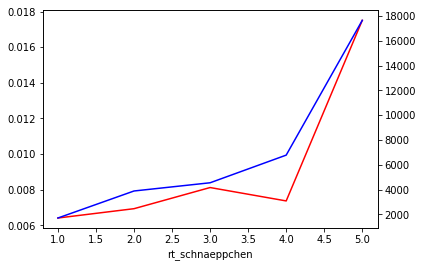

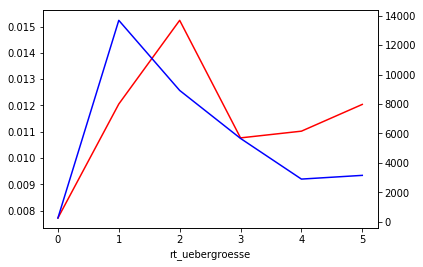

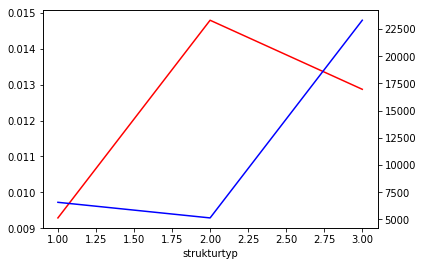

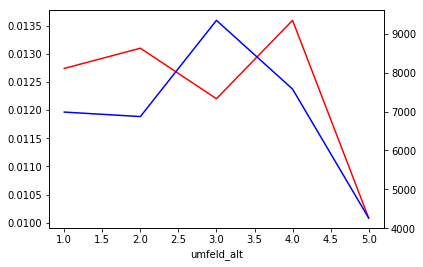

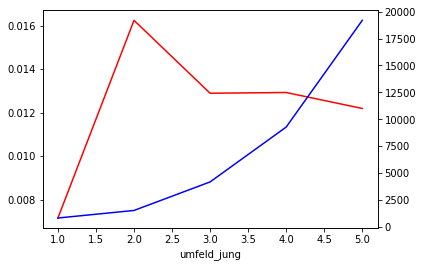

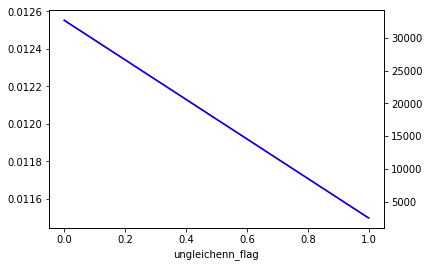

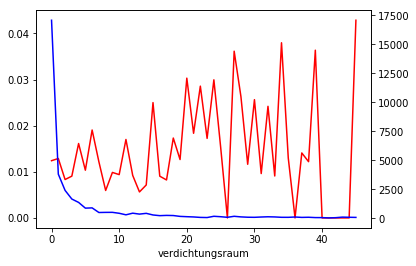

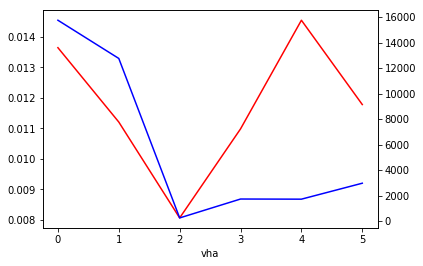

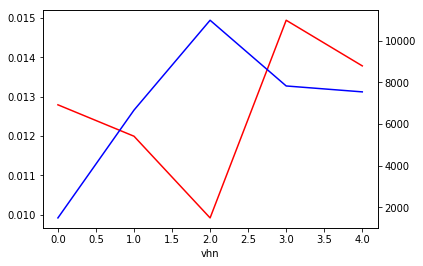

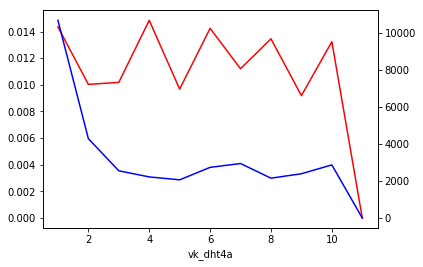

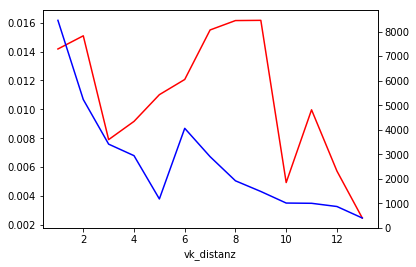

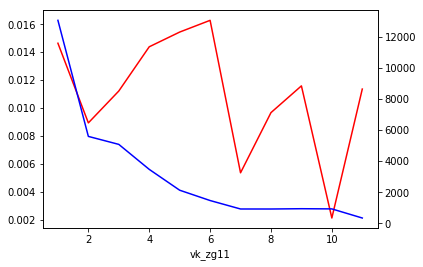

In [550]:
summer = 0

for col in col_dict['dnu']:
    if col in ['lnr', 'eingefuegt_am']: continue
        
    if 'alter_kind' in col: continue
        
    fig, ax = plt.figure(), plt.subplot(111)
    twinax = ax.twinx()
    
    train.groupby([col])['response'].mean().plot(ax = ax, color = 'red')
    train.groupby([col])['lnr'].count().plot(ax = twinax, color = 'blue')
    plt.show()
    
    summer += 1

In [77]:
dummy_list = ['akt_dat_kl', 'd19_buch_cd', 'd19_konsumtyp_max', 'd19_soziales', 'firmendichte', 'mobi_raster',\
              'rt_uebergroesse', 'strukturtyp', 'umfeld_jung', 'vha', 'vhn', 'vk_distanz', 'vk_zg11']

for col in dummy_list:
    print(col)
    dtr_df = pd.get_dummies(train[col], prefix = col, dummy_na = True)
    dte_df = pd.get_dummies(test[col], prefix = col, dummy_na = True)
    
    train = pd.concat([dtr_df, train.drop(col, axis = 1)], axis = 1)
    test = pd.concat([dte_df, test.drop(col, axis = 1)], axis = 1)

akt_dat_kl
d19_buch_cd
d19_konsumtyp_max
d19_soziales
firmendichte
mobi_raster
rt_uebergroesse
strukturtyp
umfeld_jung
vha
vhn
vk_distanz
vk_zg11


In [78]:
train.shape, test.shape

((35186, 1252), (35206, 1248))

In [79]:
leave_list = ['anz_kinder', 'anz_statistische_haushalte', 'dsl_flag', 'gemeindetyp', 'hh_delta_flag', 'kk_kundentyp',\
              'kombialter', 'konsumzelle', 'rt_kein_anreiz', 'rt_schnaeppchen', 'umfeld_alt', 'ungleichenn_flag']

for col in leave_list:
    train[col].fillna(train[col].mean(), inplace = True)
    test[col].fillna(test[col].mean(), inplace = True)

In [80]:
train.drop(list(set(col_dict['dnu']) - set(leave_list) - set(dummy_list)), axis = 1, inplace = True)
test.drop(list(set(col_dict['dnu']) - set(leave_list) - set(dummy_list)), axis = 1, inplace = True)

In [81]:
in_train = set(train.columns) - set(test.columns)
in_test = set(test.columns) - set(train.columns)

rm_cols = list(set(list(in_train) + list(in_test)) - set(col_dict['response']))

In [82]:
for col in rm_cols:
    if col in train.columns: train.drop(col, axis = 1, inplace = True)
        
    if col in test.columns: test.drop(col, axis = 1, inplace = True)
        
print('train', train.shape[1])
print('test', test.shape[1])

train 1235
test 1234


In [563]:
pd.to_pickle(train, 'train')
pd.to_pickle(test, 'test')

In [87]:
train = pd.read_pickle('train')
test = pd.read_pickle('test')

In [92]:
def build_model():
    pipeline = Pipeline([
        ('clf', GradientBoostingClassifier(random_state = 1))
    ])
    
    parameters = {
        'clf__min_samples_leaf': (5, 20), 
        'clf__learning_rate': (0.0005, 0.001),
        'clf__n_estimators': (10, 20),
        'clf__max_depth': (2, ),
        'clf__max_features': (500, 750)
    }

    cv = GridSearchCV(pipeline, param_grid = parameters, verbose = 2, return_train_score = True,\
                      n_jobs = -1, scoring = 'roc_auc')
    return cv

In [93]:
model = build_model()

In [94]:
model.fit(train[list(set(train.columns) - set(['response']))], train['response'])
pd.to_pickle(model, 'model')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=10 
[CV]  clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=10, total=   4.5s
[CV] clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=10 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=10, total=   4.0s
[CV] clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=10 
[CV]  clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=10, total=   4.0s
[CV] clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=20 
[CV]  clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=20, total=   6.1s
[CV] clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=20 
[CV]  clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, clf__n_estimators=20, total=   6.0s
[CV] clf__learning_rate=0.0005, clf__max_depth=2, clf__max_features=500, clf__min_samples_leaf=5, cl

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  5.0min finished


In [2]:
model = pd.read_pickle('model')

In [3]:
model.best_params_

{'clf__learning_rate': 0.0005,
 'clf__max_depth': 2,
 'clf__max_features': 500,
 'clf__min_samples_leaf': 20,
 'clf__n_estimators': 10}

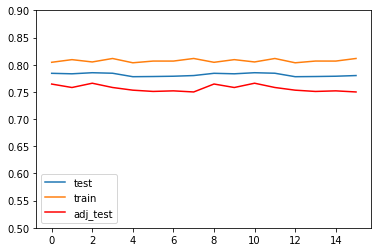

In [4]:
test_score = model.cv_results_['mean_test_score']
train_score = model.cv_results_['mean_train_score']
adj_test_score = [test_score[idx] * test_score[idx] / train_score[idx] for idx in range(len(test_score))]
max_idx = adj_test_score.index(max(adj_test_score))

fig, ax = plt.figure(), plt.subplot(111)
ax.plot(test_score, label = 'test')
ax.plot(train_score, label = 'train')
ax.plot(adj_test_score, color = 'red', label = 'adj_test')
ax.set_ylim([0.5, 0.9])
ax.legend()

In [9]:
param_list = ['param_clf__learning_rate', 
              'param_clf__min_samples_leaf',
              'param_clf__n_estimators',
              'param_clf__max_depth',
              'param_clf__max_features']

param_dict = dict(zip([param.split('__')[1] for param in param_list] + ['test', 'train'],\
                      [[], [], [], [], [], test_score, train_score]))

loop_list = [max_idx]
#loop_list = range(len(test_score))

for idx in loop_list:
    print(idx)
    for param in param_list:
        print(param, model.cv_results_[param][idx])
        if param.split('__')[1] == 'max_features' and model.cv_results_[param][idx] is None:
            param_dict[param.split('__')[1]].append(1000)
        else:
            param_dict[param.split('__')[1]].append(model.cv_results_[param][idx])
if len(loop_list) == 1:
    print(param_dict)
else:
    param_df = pd.DataFrame(param_dict)

2
param_clf__learning_rate 0.0005
param_clf__min_samples_leaf 20
param_clf__n_estimators 10
param_clf__max_depth 2
param_clf__max_features 500
{'learning_rate': [0.0005], 'min_samples_leaf': [20], 'n_estimators': [10], 'max_depth': [2], 'max_features': [500], 'test': array([ 0.7841907 ,  0.78329701,  0.78528419,  0.78433117,  0.77796404,
        0.77829502,  0.77882366,  0.78008062,  0.78420904,  0.78329642,
        0.78528419,  0.78432822,  0.77796404,  0.77829111,  0.77882366,
        0.78008101]), 'train': array([ 0.8044704 ,  0.80934893,  0.80508445,  0.81145894,  0.80356099,
        0.80672015,  0.80669124,  0.81148889,  0.80443077,  0.80934505,
        0.80508445,  0.81146017,  0.80356099,  0.8067503 ,  0.80669134,
        0.81148869])}


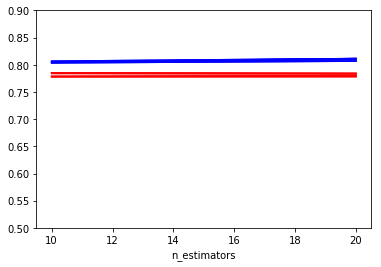

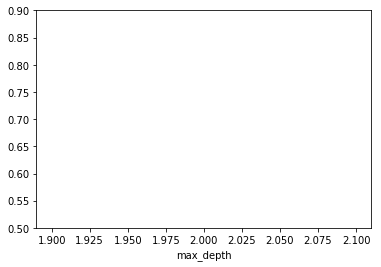

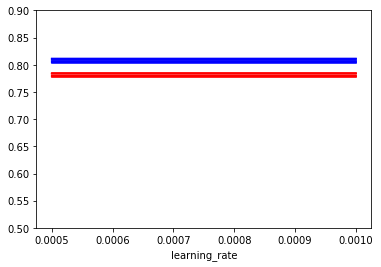

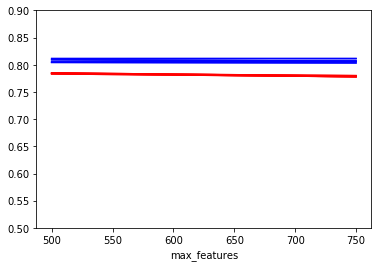

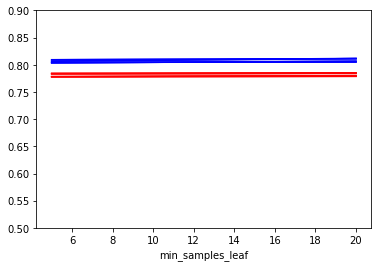

In [8]:
param_cols = list(set(param_df.columns) - set(['test', 'train']))
c_dict = dict(zip(['test', 'train'], ['red', 'blue']))
for col in param_cols:
    other_params = list(param_cols)
    other_params.remove(col)
    other_param_dict = param_df[other_params].drop_duplicates().to_dict()
    df_idxs = list(other_param_dict[other_params[0]].keys())
    
    fig, ax = plt.figure(), plt.subplot(111)
    
    for idx in df_idxs:
        for op_idx, other_param in enumerate(other_params):
            if op_idx == 0:
                use_mask = param_df[other_param] == other_param_dict[other_param][idx]
            else:
                use_mask = use_mask & (param_df[other_param] == other_param_dict[other_param][idx])
                
        use_df = param_df.loc[use_mask]
        for result in ['test', 'train']:
            use_df.groupby(col)[result].mean().plot(ax = ax, label = result, color = c_dict[result])
            
    ax.set_ylim([0.5, 0.9])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.